# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,10)

from datetime import datetime, timedelta
import math
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

### Первичный анализ данных

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
data_count1 = data['Model'].count()

In [ ]:
data.duplicated().sum()

4

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

Проблемы:
- Model - есть null, модель сильно влияет на цену. Удалим все записи без модели.
- Признаки: Price, RegistrationYear, Power имеют выбросы
- NumberOfPictures одни нули. Можно удалить признак.
- RegistrationMonth - есть нули, но наверное исправлять нет смысла.

Nulls:
- VehicleType
- Gearbox
- FuelType
- Repaired

Ровные колонки:
- DataCrawled
- Kilometer
- Brand
- DateCreated
- PostalCode
- LastSeen

In [ ]:
data.drop('NumberOfPictures', axis=1, inplace=True)

### Приведение типов

In [ ]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  PostalCode         354365 non-null  int64   

In [ ]:
data['DateCreated'].max()

Timestamp('2016-04-07 00:00:00')

Машины могут быть не моложе 2016 года выпуска.

### Обработка пропусков

In [ ]:
def print_na(df):
    df_na = pd.DataFrame(df.isna().sum())
    df_na.columns = ['count_na']
    df_na['prc'] = df_na['count_na'] / df.shape[0] * 100
    print('')
    print('Проверим пустые значения:')
    display(df_na[df_na['count_na'] > 0])

In [ ]:
print_na(data)


Проверим пустые значения:


,count_na,prc
VehicleType,37490,10.579487
Gearbox,19833,5.596772
Model,19705,5.560651
FuelType,32895,9.282802
Repaired,71154,20.079297


**Model** - один из самых важных признаков. Восстановить модель не получится. Заполним unknown

**Repaired** заполним строчным значением "unknown", т.к. объявления закачиваются из разных источников (судя по названию столбца DateCrawled), то во многих случаях nan - это скорее всего отсутствие информации, а не значние no.

Все остальные пропуски:
- требуется доп. анализ
- можно заполнить самыми часто встречаемыми значениями в записях аналогичных моделей.
- Или заполнить в том же % соотношении, что они встречаются у модели.
- вообще такое заполнение вилами на воде писано )

**VehicleType, Gearbox, FuelType** - заполним значениями "unknown", чтобы получить более достоверные результаты.

In [ ]:
#data.dropna(subset = ['Model'], inplace=True)
data['Model'] = data['Model'].fillna('unknown')

In [ ]:
data['Repaired'] = data['Repaired'].fillna('unknown')
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')

In [ ]:
print_na(data)


Проверим пустые значения:


,count_na,prc


### Обработка выбросов

Признаки: Price, RegistrationYear, Power

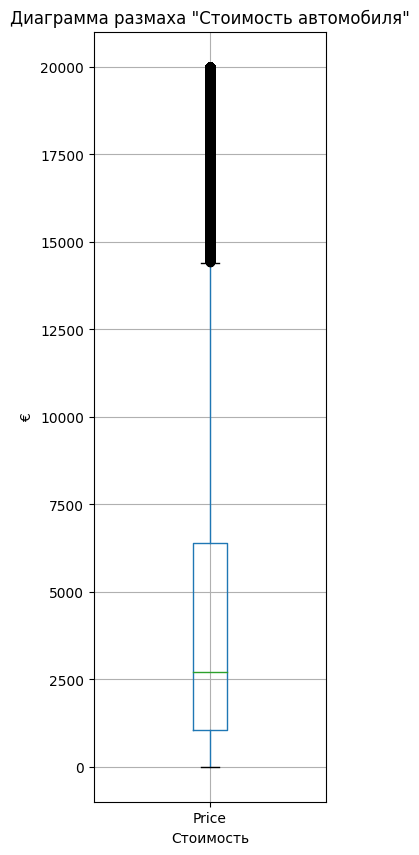

In [ ]:
data.boxplot(column=['Price'])
plt.title('Диаграмма размаха "Стоимость автомобиля"')
plt.xlabel('Стоимость')
plt.ylabel('€')
plt.show()

In [ ]:
data['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [ ]:
print('Price > 15000:', data[data['Price'] > 15000]['Price'].count())
print('Price < 500:', data[data['Price'] < 500]['Price'].count())
print('Price == 0:', data[data['Price'] == 0]['Price'].count())

Price > 15000: 14881
Price < 500: 36054
Price == 0: 10772


Очень много машин без цены. Наша задача предсказать эту цену.

Удалим записи без целевого признака.

In [ ]:
data = data.loc[data['Price'] > 500]
data = data.loc[data['Price'] < 15000]

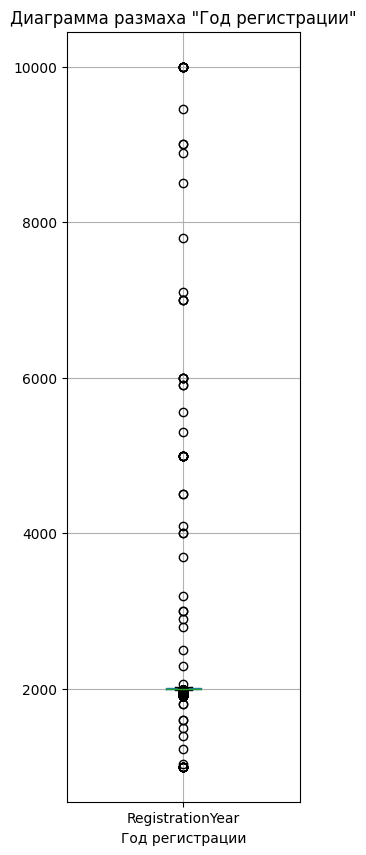

In [ ]:
data.boxplot(column=['RegistrationYear'])
plt.title('Диаграмма размаха "Год регистрации"')
plt.xlabel('Год регистрации')
plt.show()

In [ ]:
data['RegistrationYear'].describe()

count    297153.000000
mean       2003.923689
std          61.932316
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [ ]:
print('RegistrationYear > 2016:', data[data['RegistrationYear'] > 2016]['RegistrationYear'].count())
print('RegistrationYear < 1970:', data[data['RegistrationYear'] < 1970]['RegistrationYear'].count())

RegistrationYear > 2016: 12596
RegistrationYear < 1970: 846


Машины старше 1970 года выпуска - раритетные и цены обычно устанавливаются вручную. Это штучный товар.
Машины моложе 2016 года выпуска не могут быть, т.к. период объявлений заканчивается в апреле 2016 года.

Удалим их.

In [ ]:
data = data[data['RegistrationYear'] <= 2016]
data = data[data['RegistrationYear'] > 1970]

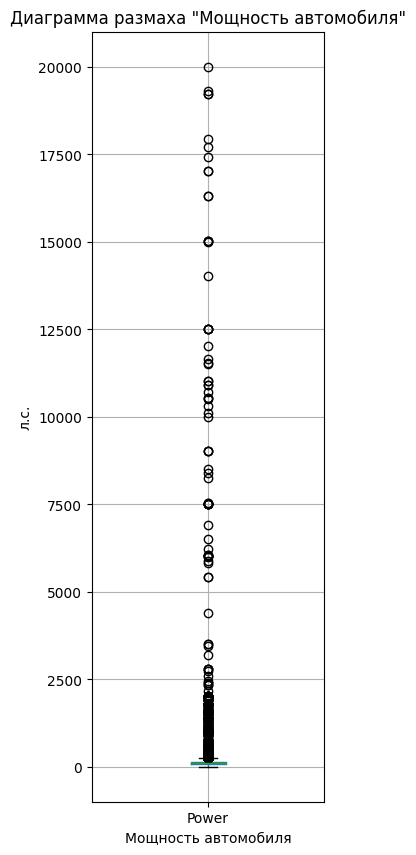

In [ ]:
data.boxplot(column=['Power'])
plt.title('Диаграмма размаха "Мощность автомобиля"')
plt.xlabel('Мощность автомобиля')
plt.ylabel('л.с.')
plt.show()

In [ ]:
data['Power'].describe()

count    283503.000000
mean        113.438468
std         185.536564
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
print('Power > 2000:', data[data['Power'] > 2000]['Power'].count())
print('Power < 50:', data.loc[(data['Power'] > 0) & (data['Power'] < 50)]['Power'].count())
print('Power = 0:', data[data['Power'] == 0]['Power'].count())

Power > 2000: 89
Power < 50: 3438
Power = 0: 23683


In [ ]:
data = data[data['Power'] <= 2000]
data = data[data['Power'] > 50]

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data_count2 = data['Model'].count()

print(f'Удалили: {round(100 - data_count2 / data_count1 * 100)}%')

Удалили: 24%


### Добавим новые столбцы

Кол-во дней в продаже:

In [ ]:
data['DaysInSale'] = (data['LastSeen'] - data['DateCreated']).dt.days

Машины продаются максимум пол года, если дольше, значит цена не адекватная или старое и уже не актуальное объявление.

In [ ]:
data[data['DaysInSale'] > 180]['Model'].count()

6

In [ ]:
InActive60Day = data['LastSeen'].max() - timedelta(days=60)

In [ ]:
data[data['LastSeen'] < InActive60Day]['Model'].count()

0

За последние 2 месяца были просмотры по каждому объявлению.

### Удалим столбцы с датой даты

In [ ]:
data = data.drop(columns=['DateCrawled','DateCreated','LastSeen'], axis=1)

### Вывод

Мы провели анализ данных и подготовили их:
- обработали пропуски
- обработали выбросы
- добавили новый столбец
- преобразовали столбцы с датами
    

## Обучение моделей

In [ ]:
RANDOM_STATE = 12345

In [ ]:
#подбор параметров
def get_best_estimator(model, params, scoring, features, target, cv):
    GSCV = GridSearchCV(model, params,
                        cv = cv, # количество разбиений на кросс-валидацию
                        scoring = scoring,
                        n_jobs=-1
                       )
    GSCV.fit(features, target)
    print(GSCV.best_estimator_)
    print('Лучшие гипепрпараметры:', GSCV.best_params_)
    print('RMSE:', -GSCV.best_score_)
    return GSCV.best_estimator_

In [ ]:
warnings.simplefilter(action='ignore')

### Подготовка выборок для обучения

In [ ]:
features = data.drop("Price", axis='columns')
target = data['Price']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
print(features_train.shape)
print(features_test.shape)

(189719, 12)
(63240, 12)


**Для линейных моделей преобразуем данные**

#### OneHotEncoder

In [ ]:
categorial_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Model', 'Brand']

In [ ]:
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='error')
ohe.fit(features_train[categorial_cols])

OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [ ]:
def encode_ohe(df, _ohe, cols):
    temp_df = pd.DataFrame(data=_ohe.transform(df[cols]), columns=_ohe.get_feature_names_out(cols), index=df.index)
    temp_df2 = df.drop(columns=cols, axis=1)
    return pd.concat([temp_df2, temp_df], axis=1)

In [ ]:
lr_features_train = encode_ohe(features_train, ohe, categorial_cols)
lr_features_test = encode_ohe(features_test, ohe, categorial_cols)

### LinearRegression

#### Обучим модель

In [ ]:
#params = { "positive": [True, False], "fit_intercept": [True, False] } для линейной регрессии параметры не перебираются
#а настраиваются в зависимости от того, как подготовлены данные
params = {}

**Подбор гиперпараметров**

In [ ]:
model = LinearRegression()

model = get_best_estimator(model, params, 'neg_root_mean_squared_error', lr_features_train, target_train, cv=3)

LinearRegression()
Лучшие гипепрпараметры: {}
RMSE: 2128.486486894781


**Лучшие параметры**

LinearRegression()

**RMSE**: 2128.4864868947557

In [ ]:
model = LinearRegression()

In [ ]:
%%time

model.fit(lr_features_train, target_train)

CPU times: user 13.7 s, sys: 1.82 s, total: 15.5 s
Wall time: 7.09 s


LinearRegression()

**Время обучения**
Wall time: 26.7 s

In [ ]:
%%time

predicted_train = model.predict(lr_features_train)

CPU times: user 289 ms, sys: 161 ms, total: 449 ms
Wall time: 348 ms


**Время предсказания** Wall time: 364 ms

### ElasticNet

In [ ]:
params = {
    "alpha": [0.1, 0.5, 0.9],
    "l1_ratio": [0.1, 0.5, 0.9],
    "max_iter": [100, 500, 1000],
}

**Подбор гиперпараметров**

In [ ]:
model = ElasticNet(random_state=RANDOM_STATE)
model = get_best_estimator(model, params, 'neg_root_mean_squared_error', lr_features_train, target_train, cv=3)

ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=100, random_state=12345)
Лучшие гипепрпараметры: {'alpha': 0.1, 'l1_ratio': 0.9, 'max_iter': 100}
RMSE: 2239.5750633259795


In [ ]:
model = ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=100, random_state=RANDOM_STATE)

In [ ]:
%%time

model.fit(lr_features_train, target_train)

CPU times: user 19.9 s, sys: 1.82 s, total: 21.8 s
Wall time: 7.79 s


ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=100, random_state=12345)

**Время обучения**
Wall time: 1min 5s

In [ ]:
%%time

predicted_train = model.predict(lr_features_train)

CPU times: user 329 ms, sys: 191 ms, total: 520 ms
Wall time: 325 ms


**Время предсказания** Wall time: 428 ms

### CatBoost

**1 приближение**

In [ ]:
params = {
    "depth": [9, 12],
    "learning_rate": [0.1, 0.2, 0.4, 0.6],
    "iterations": [100, 150, 200],
    "random_state": [RANDOM_STATE]
}

**глубина 12 - лучше, iterations >= 200 долго**

**лучшая модель - depth = 12, learning_rate=0.2, iterations=200**, ~2мин

**2 приближение**

попробуем оптимизировать скорость

In [ ]:
params = {
    "depth": [12],
    "learning_rate": [0.3, 0.25, 0.2],
    "iterations": [175, 200],
}

In [ ]:
model = CatBoostRegressor(loss_function='RMSE', cat_features=categorial_cols, random_state=RANDOM_STATE)

**Подбор гиперпараметров**

In [ ]:
model = model.grid_search(params,
                          X=features_train,
                          y=target_train,
                          verbose=False,
                          plot=True
                         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4381.1235535	test: 4352.6879927	best: 4352.6879927 (0)	total: 123ms	remaining: 21.5s
1:	learn: 3370.3897076	test: 3346.9408877	best: 3346.9408877 (1)	total: 189ms	remaining: 16.3s
2:	learn: 2715.5411079	test: 2698.4131633	best: 2698.4131633 (2)	total: 250ms	remaining: 14.3s
3:	learn: 2288.6534549	test: 2278.2533369	best: 2278.2533369 (3)	total: 319ms	remaining: 13.6s
4:	learn: 2027.5260615	test: 2025.2145221	best: 2025.2145221 (4)	total: 403ms	remaining: 13.7s
5:	learn: 1828.3180655	test: 1837.6019664	best: 1837.6019664 (5)	total: 470ms	remaining: 13.2s
6:	learn: 1707.4058361	test: 1717.6665587	best: 1717.6665587 (6)	total: 528ms	remaining: 12.7s
7:	learn: 1615.1493425	test: 1630.3871037	best: 1630.3871037 (7)	total: 595ms	remaining: 12.4s
8:	learn: 1558.5798358	test: 1577.6984341	best: 1577.6984341 (8)	total: 663ms	remaining: 12.2s
9:	learn: 1522.0573235	test: 1543.4532699	best: 1543.4532699 (9)	total: 728ms	remaining: 12s
10:	learn: 1495.4682704	test: 1520.2731593	best: 152

<div>
    <b>Лучшие параметры</b>
    <pre>CatBoostRegressor(loss_function='RMSE',
                      cat_features=categorial_cols,
                      depth=12,
                      learning_rate=0.2,
                      iterations=200,
                      random_state=RANDOM_STATE
                     )
    </pre>
    <b>RMSE</b>: 1300.485925 <br>
    <b>Время обучения</b>: Wall time: 2min 12s<br>
    <b>Время предсказания</b>: Wall time: 764 ms<br>
</div>
<br>
<div>
    <b>Оптимальные по времени обучения</b>
    <pre>CatBoostRegressor(loss_function='RMSE',
                      cat_features=categorial_cols,
                      depth=12,
                      learning_rate=0.25,
                      iterations=175,
                      random_state=RANDOM_STATE
                     )
    </pre>
    <b>RMSE</b>: 1314.880<br>
    <b>Время обучения</b>: Wall time: 35.8 s<br>
    <b>Время предсказания</b>: Wall time: 409 ms
</div>

In [ ]:
model = CatBoostRegressor(loss_function='RMSE',
                          cat_features=categorial_cols,
                          depth=12,
                          learning_rate=0.25,
                          iterations=175,
                          random_state=RANDOM_STATE
                         )

In [ ]:
%%time

model.fit(features_train, target_train,
          verbose=False
         )

CPU times: user 40.7 s, sys: 779 ms, total: 41.5 s
Wall time: 18.3 s


In [ ]:
%%time

predicted_train = model.predict(features_train)

CPU times: user 351 ms, sys: 6.86 ms, total: 358 ms
Wall time: 227 ms


### LightGBM

#### Подготовка выборок

In [ ]:
lgbm_features_train = features_train.copy()
lgbm_features_test = features_test.copy()

In [ ]:
lbl_enc = LabelEncoder()
for col in categorial_cols:
    lbl_enc.fit(features_train[col])
    lgbm_features_train[col] = lbl_enc.transform(lgbm_features_train[col])
    lgbm_features_test[col] = lbl_enc.transform(lgbm_features_test[col])

In [ ]:
for col in categorial_cols:
    lgbm_features_train[col] = lgbm_features_train[col].astype('int')
    lgbm_features_test[col] = lgbm_features_test[col].astype('int')

#### Обучение модели

In [ ]:
params = {
    "max_depth": [12],
    "learning_rate": [0.3, 0.25, 0.2],
    "n_estimators": [175, 200]
}

**Подбор гиперпараметров**

In [ ]:
model = LGBMRegressor(objective='rmse', boosting_type='gbdt')
model = get_best_estimator(model, params, 'neg_root_mean_squared_error', lgbm_features_train, target_train, cv=3)

LGBMRegressor(learning_rate=0.25, max_depth=12, n_estimators=200,
              objective='rmse')
Лучшие гипепрпараметры: {'learning_rate': 0.25, 'max_depth': 12, 'n_estimators': 200}
RMSE: 1344.409257645488


<div>
    <b>Лучшие параметры</b>
    <pre>LGBMRegressor(learning_rate=0.25,
                       max_depth=12,
                       n_estimators=200,
                       objective='rmse'
                      )
    </pre>
    <b>RMSE</b>: 1344.409257645488<br>
    <b>Время обучения</b>: Wall time: 2min 48s<br>
    <b>Время предсказания</b>: Wall time: 2.77 s
</div>

In [ ]:
model = LGBMRegressor(learning_rate=0.25, max_depth=12, n_estimators=200,
              objective='rmse', random_state=RANDOM_STATE)

In [ ]:
%%time

model.fit(lgbm_features_train, target_train,
          categorical_feature=categorial_cols
         )

CPU times: user 2.84 s, sys: 87.5 ms, total: 2.93 s
Wall time: 834 ms


LGBMRegressor(learning_rate=0.25, max_depth=12, n_estimators=200,
              objective='rmse', random_state=12345)

In [ ]:
%%time

predicted_train = model.predict(lgbm_features_train)

CPU times: user 2.31 s, sys: 28.9 ms, total: 2.34 s
Wall time: 637 ms


## Анализ моделей

**Результаты:**

- LinearRegression
    - Время обучения 26.7 s
    - Время предсказания 364 ms
    - RMSE 2128.4864868947557
    
    
- ElasticNet
    - Время обучения 1min 5s
    - Время предсказания 428 ms
    - RMSE 2239.5750633259786


- CatBoost
    - Время обучения 35.8 s
    - Время предсказания 409 ms
    - RMSE 1314.880
    
    
- LightGBM
    - Время обучения 2min 48s (после перезапуска ядра 7.76 s)
    - Время предсказания 2.77 s
    - RMSE 1344.409257645488

Все модели подходят по точности RMSE, но:

LinearRegression - быстро, но качество модели заметно хуже, чем модели градиентного бустинга

LightGBM - качество сравнимое с CatBoost, но время предсказания дольше.

CatBoost - идеально подходит под условия задачи

## Финальная модель CatBoost

In [ ]:
model = CatBoostRegressor(loss_function='RMSE',
                          cat_features=categorial_cols,
                          depth=12,
                          learning_rate=0.25,
                          iterations=175,
                          random_state=RANDOM_STATE
                         )

In [ ]:
%%time

model.fit(features_train, target_train,
          verbose=False
         )

CPU times: user 40.9 s, sys: 614 ms, total: 41.5 s
Wall time: 15 s


In [ ]:
%%time

predicted_test = model.predict(features_test)

CPU times: user 125 ms, sys: 4.07 ms, total: 129 ms
Wall time: 92.4 ms


In [ ]:
print('RMSE:',mean_squared_error(target_test, predicted_test, squared=False))

RMSE: 1289.036679235991


### Сравнение с DummyRegressor

In [ ]:
model = DummyRegressor()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('RMSE:',mean_squared_error(target_test, predicted_test, squared=False))

RMSE: 3669.3758941403908


## Вывод

Необходимо было найти модель, которая быстро и качественно предсказывала значения стоимости автомобиля по параметрам.
Ориентеровочное качество модели - RMSE <= 2500.

- Для этого мы проанализировали, обработали и подготовили данные.
- Проанализировали разные алгоритмы машинного обучения и подобрали для них оптимальные гиперпараметры.
- Сравнили полученные результаты и выбрали оптимальную модель

Лучшая модель:
- CatBoost
    - Время обучения 35.8 s
    - Время предсказания 409 ms
    - RMSE 1314.880
    
Модель адекватна - результаты лучше, чем у DummyRegressor